## V_MRDH model: OD demand for different modalities

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#### OD matrices

In [14]:
modalities = ["Auto", "Fiets", "OV"]
periods = ["os", "rd", "as"]  # ochtendspits (7-9), restdag, avondspits (16-18)

od = {}

for modality in modalities:
    for period in periods:
        od[modality, period] = pd.read_excel('V_MRDH_MatComp_2020.xlsx', sheet_name=f"{modality}_{period}", index_col=0, usecols='A:BN', nrows=65)
                                 
od_etm = {}
for modality in modalities:
    od_etm[modality] = pd.read_excel('V_MRDH_MatComp_2020.xlsx', sheet_name=f"{modality}_etm", index_col=0, usecols='A:BN', nrows=65)

In [15]:
od_etm["Auto"].head(5)

,Centrum,Delfshaven,Noord,Kralingen,IJsselmonde (bi),Feyenoord,Charlois,Overschie,HillegersbergSchiebroek,Prins Alexander,...,Dordrecht,Overig Drechtsteden,Hoekse Waard,Goeree,Zeeland,Brabant Limburg,Gelderland Utrecht,Overijssel,Gro Frie Dren,NHolland Flevoland
Centrum,3976,3503,2432,2770,806,2824,1415,1138,1495,1271,...,473,422,777,173,265,2139,868,56,38,552
Delfshaven,3467,10085,2674,1915,698,2391,1883,2949,1575,949,...,489,380,593,127,171,1123,724,37,19,526
Noord,2505,2757,5088,2816,452,1509,864,2827,3719,1539,...,356,278,309,82,110,758,681,28,14,457
Kralingen,2917,1964,2827,8183,1499,2488,1047,1083,2461,4620,...,603,594,516,107,199,1353,1234,55,32,720
IJsselmonde (bi),876,699,448,1439,18147,5256,2794,173,416,1481,...,611,1324,1370,190,161,1280,655,35,18,225


In [16]:
# Create a dict with the area names
area_name_dict = {n: name for n, name in zip(range(1, 66), od["Auto", "os"].index)}

{1: 'Centrum',
 2: 'Delfshaven',
 3: 'Noord',
 4: 'Kralingen',
 5: 'IJsselmonde (bi)',
 6: 'Feyenoord',
 7: 'Charlois',
 8: 'Overschie',
 9: 'HillegersbergSchiebroek',
 10: 'Prins Alexander',
 11: 'IJsselmonde (bui)',
 12: 'Hoek van Holland',
 13: 'Hoogvliet',
 14: 'Rozenburg',
 15: 'Eemhaven Waalhaven',
 16: 'Vondelingenplaat',
 17: 'Botlek',
 18: 'Europoort',
 19: 'Maasvlakte',
 20: 'Centrum',
 21: 'Laak',
 22: 'Escamp',
 23: 'Loosduinen',
 24: 'Segbroek',
 25: 'Scheveningen',
 26: 'Haagse Hout',
 27: 'Leidschenveen',
 28: 'Albrandswaard',
 29: 'Barendrecht',
 30: 'Brielle',
 31: 'Capelle aan den IJssel',
 32: 'Delft',
 33: 'Hellevoetssluis',
 34: 'Krimpen aan den IJssel',
 35: 'Lansingerland',
 36: 'Leidschendam',
 37: 'Maassluis',
 38: 'Midden Delfland',
 39: 'Nissewaard',
 40: 'Pijnacker',
 41: 'Ridderkerk',
 42: 'Rijswijk',
 43: 'Schiedam binnen',
 44: 'Schiedam buiten',
 45: 'Vlaardingen',
 46: 'Wassenaar',
 47: 'Westland',
 48: 'Westvoorne',
 49: 'Zoetermeer',
 50: 'DuinBollens

In [4]:
# Add the number for each column and index
for modality in modalities:
    for period in periods:
        od[modality, period].columns = range(1, 66)
        od[modality, period].index = range(1, 66)
    od_etm[modality].columns = range(1, 66)
    od_etm[modality].index = range(1, 66)

In [5]:
# Calculate the total demand for each period
od_totaal = {}
for period in periods:
    od_totaal[period] = sum(od[modality, period] for modality in modalities)

od_totaal_etm = sum(od_etm[modality] for modality in modalities)

### Inbound / outbound traffic

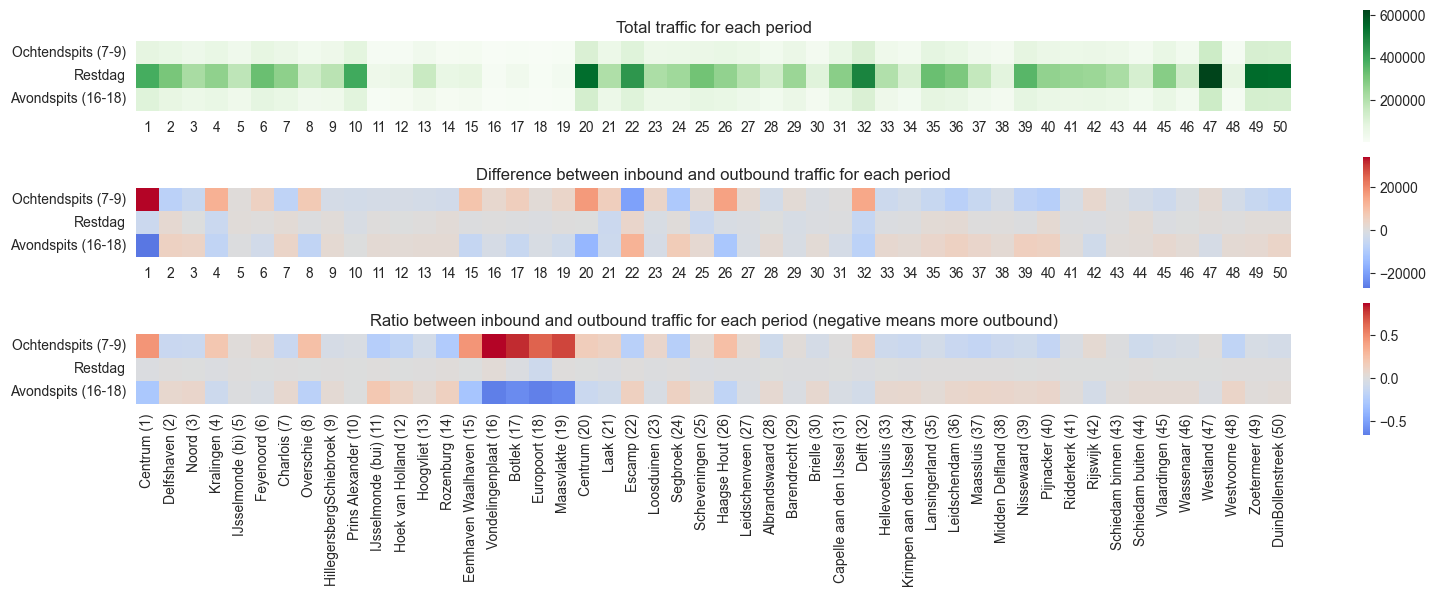

In [22]:
# Calculate the total inbound and outbound traffic for area 1 to 65 in each period
inbound = {}
outbound = {}
diff = {}
for period in periods:
    inbound[period] = od_totaal[period].sum(axis=0)
    outbound[period] = od_totaal[period].sum(axis=1)
    diff[period] = inbound[period] - outbound[period]

inbound_df = pd.DataFrame(inbound)
outbound_df = pd.DataFrame(outbound)
total_df = inbound_df + outbound_df
diff_df = pd.DataFrame(diff)
ratio_df = diff_df.div(total_df, axis=0)

# Plot heatmaps of the diff df
fig, ax = plt.subplots(3, 1, figsize=(16, 6))
# Use another color map for total_df, starting at white: 
sns.heatmap(total_df.iloc[:50, :].T, cmap="Greens", square=True, ax=ax[0])
ax[0].set_title("Total traffic for each period")
sns.heatmap(diff_df.iloc[:50, :].T, cmap='coolwarm', center=0, square=True, ax=ax[1])
# Add a title
ax[1].set_title("Difference between inbound and outbound traffic for each period")
sns.heatmap(ratio_df.iloc[:50, :].T, cmap='coolwarm', center=0, square=True, ax=ax[2])
ax[2].set_title("Ratio between inbound and outbound traffic for each period (negative means more outbound)")
# Set the y-axis labels Ochtendspits, Restdag, Avondspits
for x in ax:
    x.set_yticklabels(["Ochtendspits (7-9)", "Restdag", "Avondspits (16-18)"], rotation=0)
    
# Use the full area names in the last plot
ax[2].set_xticklabels([f"{area_name_dict[i]} ({i})" for i in range(1, 51)], rotation=90)

plt.tight_layout()
plt.savefig(f"../img/inbound_outbound_traffic.png", dpi=300, bbox_inches='tight')

In [7]:
# Normalize over the row, so that the sum of each row is 1
od_totaal_norm = {}
for modality, df in od_totaal.items():
    od_totaal_norm[modality] = df.div(df.sum(axis=1), axis=0)

# Normalize: given a modality and origin, what is the chance of going to a certain destination (sum of chances is 1). Create a nested dictionary: period -> origin -> destination -> chance
od_chance_dict = {}
for period in periods:
    od_chance_dict[period] = {}
    odc = od_totaal[period]
    for origin in odc.index:
        od_chance_dict[period][origin] = {}
        total = odc.loc[origin].sum()
        for destination in odc.columns:
            volume = odc.at[origin, destination]
            if volume > 0:
                od_chance_dict[period][origin][destination] = volume / total

print(od_chance_dict["rd"][3][1])
# Check if the sum of chances is 1
print(sum(od_chance_dict["os"][1].values()))

# save the dictionaries
with open('../data/od_chance_dicts_periods.pickle', 'wb') as f:
    pickle.dump(od_chance_dict, f)

0.11911849040115786
0.9999999999999998


### External car traffic

In [8]:
# TODO
# Create a numpy array with the car traffic from the external areas to the city areas and visa versa
int_mrhd65_areas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 28, 29, 31, 34, 41, 43, 44, 45]
ext_mrdh65_areas = [14, 32, 35, 37, 38, 39, 40, 53, 54, 55, 56, 57, 58]

In [9]:
# Area numbers are from:
#     # UXsim world (from traffic.py)
#     self.uw = get_uxsim_world(save_mode=False, show_mode=True)
#     # mrdh65 areas without population but covered in the network
#     self.mrdh65s_ext = list(set(self.uw.node_mrdh65_dict.keys()) - set(self.mrdh65s))
#     self.mrdh65s_ext.remove(0)
#     print(f"MRDH65 areas: {self.mrdh65s} (total {len(self.mrdh65s)}), extended areas: {self.mrdh65s_ext} (total {len(self.mrdh65s_ext)})")

NameError: name 'areas_65' is not defined

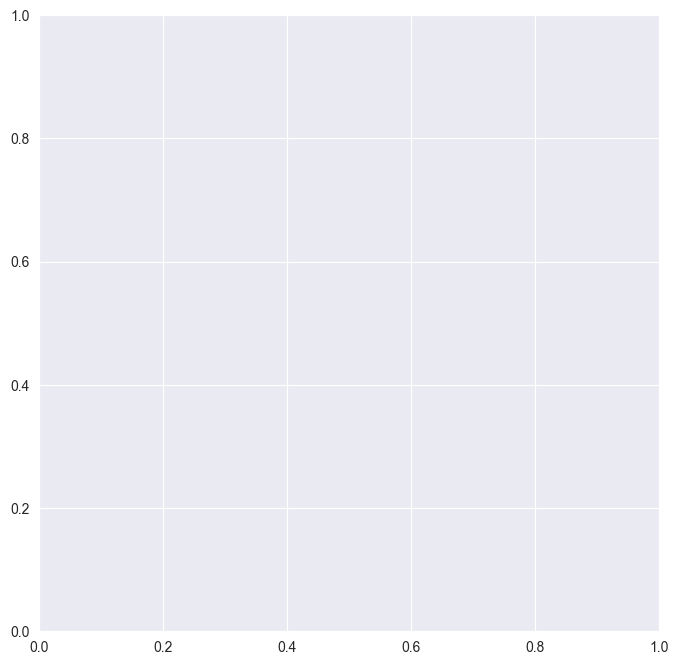

In [10]:
# Plot the internal and external areas
fig, ax = plt.subplots(figsize=(8, 8))
areas_65.loc[int_mrhd65_areas].plot(ax=ax, color='red', alpha=0.5)
areas_65.loc[ext_mrdh65_areas].plot(ax=ax, color='blue', alpha=0.5)
ax.set_title("Areas with simulated population (red) and without simulated population (blue)")
plt.savefig(f"../img/internal_external_areas.png", dpi=300, bbox_inches='tight')

In [ ]:
# Create a selection of od. Use uint16 datatype to save memory
od_ext_into_city = od["Auto"].loc[ext_mrdh65_areas, int_mrhd65_areas].astype('uint16')
od_ext_out_city = od["Auto"].loc[int_mrhd65_areas, ext_mrdh65_areas].astype('uint16')

# Save both as pickle
od_ext_into_city.to_pickle('../data/od_ext_into_city.pkl')
od_ext_out_city.to_pickle('../data/od_ext_out_city.pkl')